In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_csv('./results/times.csv')

def shortenName(benchString):
    return benchString.replace('de.tu_darmstadt.stg.daimpl.causality.benchmarks.ForkEventJoinSendReceiveBenchmark.' , '')

def fixFloatWithCommas(floatAsString):
    if isinstance(floatAsString, str):
        return float(floatAsString.replace(',','.'))
    else:
        return floatAsString

df['Score'] = df['Score'].map(fixFloatWithCommas)
df['Score Error (99,9%)'] = df['Score Error (99,9%)'].map(fixFloatWithCommas)
df['Benchmark'] = df['Benchmark'].map(shortenName)
df.drop(columns=['Threads', 'Samples'], inplace=True)
df

,Benchmark,Mode,Score,"Score Error (99,9%)",Unit,Param: generationParams,Param: programLength
0,testIntervalTreeClock,avgt,0.069136,0.113436,s/op,"1,25,25,25,25",10000
1,testIntervalTreeClock,avgt,0.122159,0.004017,s/op,"1,25,25,25,25",20000
2,testIntervalTreeClock,avgt,1.160471,0.049898,s/op,"1,25,25,25,25",40000
3,testIntervalTreeClock,avgt,11.755849,1.097178,s/op,"1,25,25,25,25",80000
4,testIntervalTreeClock,avgt,0.011412,0.000326,s/op,"1,70,5,5,20",10000
...,...,...,...,...,...,...,...
123,de.tu_darmstadt.stg.daimpl.causality.benchmark...,ss,0.262933,NaN,s/op,"10,60,0,0,40",80000
124,de.tu_darmstadt.stg.daimpl.causality.benchmark...,ss,0.241886,NaN,s/op,"100,60,0,0,40",10000
125,de.tu_darmstadt.stg.daimpl.causality.benchmark...,ss,0.426535,NaN,s/op,"100,60,0,0,40",20000
126,de.tu_darmstadt.stg.daimpl.causality.benchmark...,ss,0.759637,NaN,s/op,"100,60,0,0,40",40000


In [3]:
def paramsToDescription(generationParams: str) -> str:
    paramArray = generationParams.split(',')
    return f"init={paramArray[0]}, E={paramArray[1]}%, F={paramArray[2]}%, J={paramArray[3]}%, S&R={paramArray[4]}%"

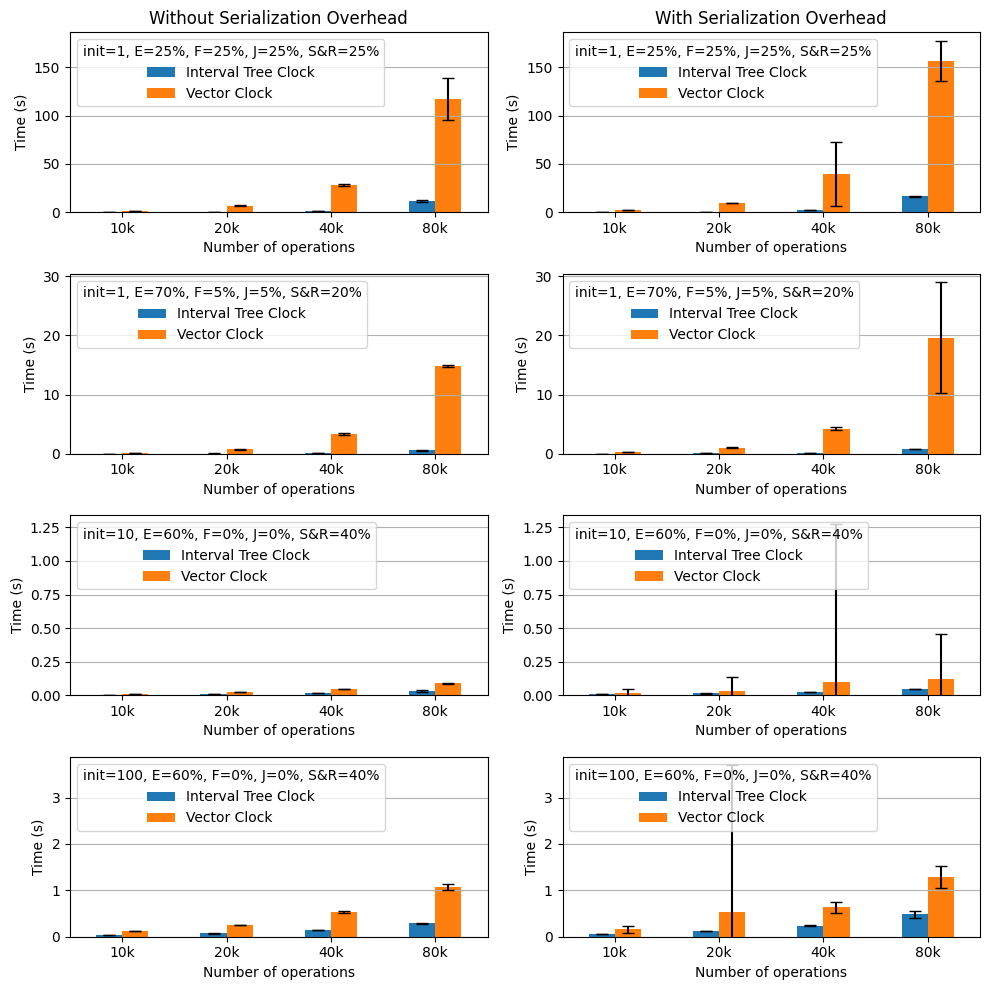

In [4]:
fig, axs = plt.subplots(4,2, figsize=(10,10))

axs[0][0].set_title('Without Serialization Overhead')
axs[0][1].set_title('With Serialization Overhead')

for ((ax_left, ax_right), param) in zip(axs, ['1,25,25,25,25', '1,70,5,5,20', '10,60,0,0,40', '100,60,0,0,40']):
    yMax = 0
    for (cur_ax, benchmarks) in [(ax_left, ['testIntervalTreeClock', 'testVectorClock']), (ax_right, ['testIntervalTreeClockWithSerialization', 'testVectorClockWithSerialization'])]:
        curBenchmarksDf = df[(df['Param: generationParams'] == param) & (df['Benchmark'].isin(benchmarks))]
        curBenchmarksDf = curBenchmarksDf.pivot(index='Param: programLength', columns='Benchmark', values=['Score', 'Score Error (99,9%)'])
        curBenchmarksDf.plot.bar(ax=cur_ax, y='Score', yerr='Score Error (99,9%)', capsize=4)
        cur_ax.set_xticklabels(curBenchmarksDf.index.map(lambda x: f"{int(x/1000)}k"), rotation=0)
        
        yMax = max(yMax, (curBenchmarksDf['Score'] + curBenchmarksDf['Score Error (99,9%)']).max().max())
    
    for ax in [ax_left, ax_right]:
        ax.set_ylim(0, yMax*1.05)
        ax.set_ylabel('Time (s)')
        ax.set_xlabel('Number of operations')
        ax.grid(axis='y')
        ax.legend(labels=['Interval Tree Clock', 'Vector Clock'], loc='upper left', title=paramsToDescription(param))

plt.tight_layout()

In [5]:
def avg_bandwidth(df: pd.DataFrame) -> pd.DataFrame:
    new_df = df[df.index % 100 == 0]
    new_df = new_df.diff()
    new_df /= 1024
    new_df = new_df.drop(index=new_df.index[0], axis=0)
    new_df = new_df.rename(columns={'bandwidth (bytes)': 'bandwidth (KiB/100ops)'})
    return new_df

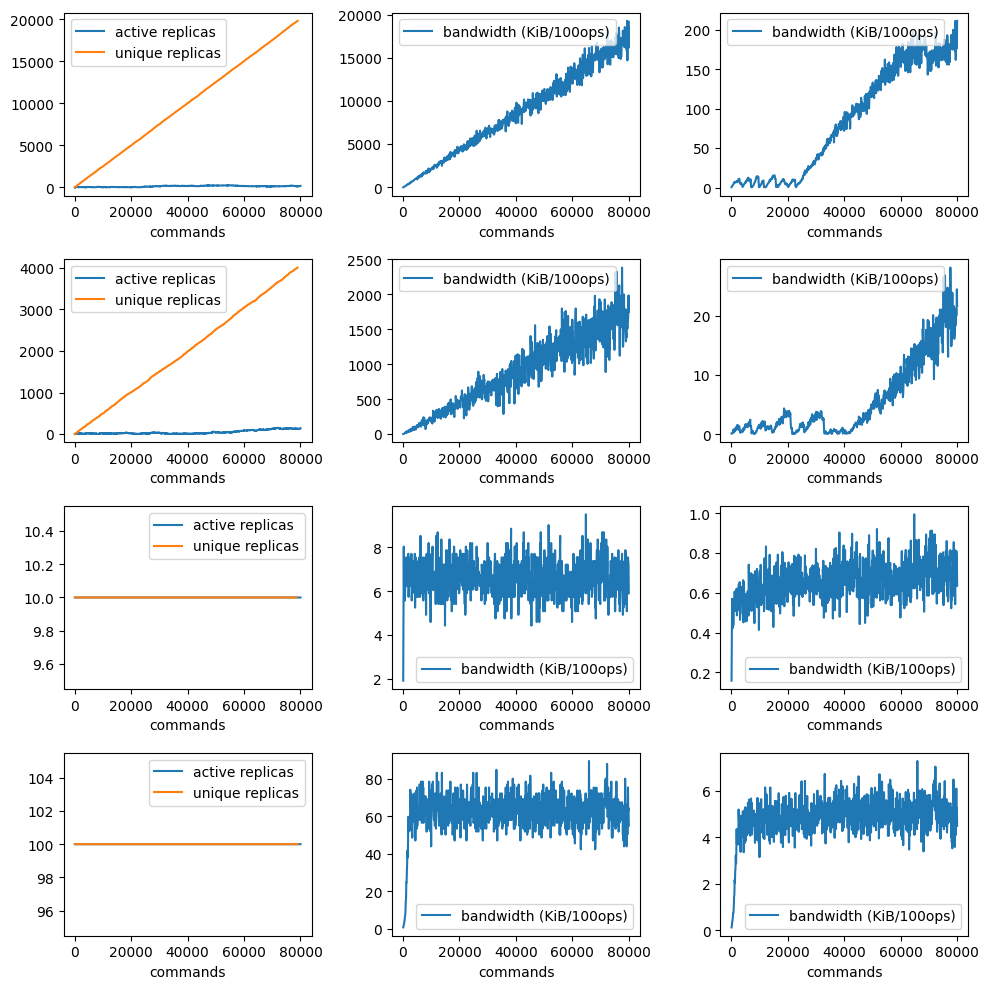

In [6]:
fig, axs = plt.subplots(4, 3, figsize=(10,10))

for ((ax1, ax2, ax3), param) in zip(axs, ['1,25,25,25,25', '1,70,5,5,20', '10,60,0,0,40', '100,60,0,0,40']):
    active_replicas = pd.read_csv(f'./results/active-replicas-{param}-80000.csv')
    active_replicas.plot(ax=ax1, x='commands', y='active replicas')
    unique_replicas = pd.read_csv(f'./results/all-replicas-{param}-80000.csv')
    unique_replicas.plot(ax=ax1, x='commands', y='unique replicas')

    bandwidth_vc = pd.read_csv(f'./results/vc-bandwidth-{param}-80000.csv').set_index('commands')
    bandwidth_vc = avg_bandwidth(bandwidth_vc)
    bandwidth_vc.plot(ax=ax2)
    
    bandwidth_itc = pd.read_csv(f'./results/itc-bandwidth-{param}-80000.csv').set_index('commands')
    bandwidth_itc = avg_bandwidth(bandwidth_itc)
    bandwidth_itc.plot(ax=ax3)
    
    
plt.tight_layout()